In [1]:
import numpy as np
import pylab as pl
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import scipy.stats as spst
import scipy.special as spspec
import time
import cgal_functions as cf

In [2]:
##########################
# Parameters
#  and
# Initialization
##########################

#This variable is referenced for plotting and in the initial data
eps = 0.0

#n is the dim of the matrix
n = 32

#Creat a rank 2 sparse matrix Y with random entries uniformly in [-1,1]
#specify the distribution
rvs = spst.uniform(loc=-1, scale=2).rvs
#choose a sparsity, higher = more nonzero entries
sparsity = 0.1
#generate sparse vector
y = sp.random(n, 1, sparsity, data_rvs = rvs).A
#exterior product for low rank sparse matrix
Y = y.dot(y.transpose())

#Perturb Y with a matrix with random entries uniformly in [-eps, eps]
eps = 0.00
#generate the perturbation matrix
pert = eps * (sp.random(n, n, 1, data_rvs = rvs).A)
#perturb Y
Ypert = Y + pert

#dens in [0,1], higher = more visible entries
dens = 0.8
#generate the mask and variables
mask, mask_ind, rav_mask_ind = cf.mask_mat(Y, dens)
#mask the matrix Ypert
Yp_masked = cf.mask_op(Ypert, rav_mask_ind)

toload = str(n)

#apply the mask to Ypert
Yp_masked = cf.mask_op(Ypert, rav_mask_ind)

#nuc norm rad
Y_nuc = np.linalg.norm(Ypert, ord='nuc')

#l1 vec norm rad
Y_l1 = np.linalg.norm(Ypert.flatten(), ord=1)

#vector of norms
Y_norm = np.array([Y_nuc, Y_l1])

#vector of radii of balls
delta =  0.5 * Y_norm

itera = 100000



In [3]:
##################
# CGAL test
##################

#m is the number of components in product space for cgal
m = 2

#set initial variables for cgal
prod_X = np.zeros((m, n, n))
prod_Mu = np.zeros((m, n, n))

#weights for product space for cgal
omega0 = 0.5
omega1 = 0.5
omega = np.array([omega0, omega1])

#weight for main objective function nu0|omega(x_1)-y|_1 + nu1|omega(x_2)-y|_1
#for cgal
nu0 = 0.5
nu1 = 1-nu0
nu = np.array([nu0, nu1])

#run cgal once to get solutions
sol_X, sol_Mu = cf.cgal(prod_X, prod_Mu, Yp_masked, mask, mask_ind, rav_mask_ind, omega, nu, delta, itera)

#compute the lagrangian at the solution
#sol_lagr = cf.lagrangian(sol_X, sol_Mu, Yp_masked, rav_mask_ind, omega, nu)

#run cgal again collecting lagrangian values
#cgal_prod_X, cgal_prod_Mu, lagr_vals = cf.cgal_lagr(prod_X, prod_Mu, sol_X, sol_Mu, Yp_masked, mask, mask_ind, rav_mask_ind, omega, nu, delta, itera)

#compute the difference between lagrangians
#lagr_vals = (lagr_vals - sol_lagr)/sol_lagr

In [4]:
##################
# GFB test
##################


#set initial variables for gfb
gfb_X = np.zeros((m+1, n, n))

#run gfb once to get solutions
gfb_sol_X, gfb_prod_X = cf.gfb(gfb_X, Yp_masked, mask, mask_ind, rav_mask_ind, delta, itera/50)

#compute the objective value at the last iterate of gfb
sol_obj = np.linalg.norm(cf.mask_op(gfb_sol_X, rav_mask_ind) - Yp_masked, ord=1)

#compute vstar from the solutions from gfb
vstar = cf.vstarf(gfb_sol_X, gfb_prod_X)

#reset initial variables
ggg_X = np.zeros((m+1, n, n))

#run gfb again but collect bregman divergence values
ggg_sol_X, breg_vals= cf.gfb_breg(ggg_X, gfb_sol_X, sol_obj, vstar, Yp_masked, mask, mask_ind, rav_mask_ind, delta, itera/50)



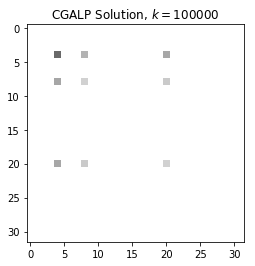

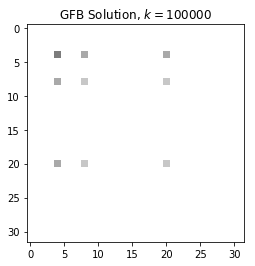

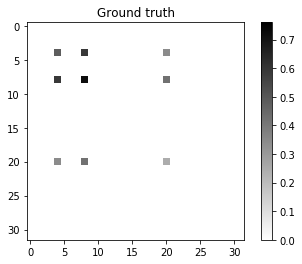

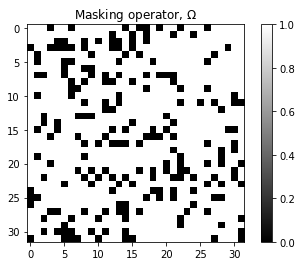

0.5825755015615525
0.5532559369296104
0.0
0.0


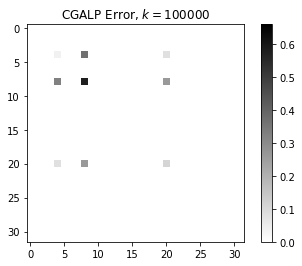

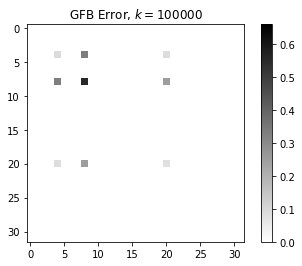

In [23]:
#These variables help make the plot visually interpretable
vmaxbuffer = .76
vminbuffer = 0
colorchoice = 'gist_gray_r'
#Show the recovered "image" from CGALP
pl.imshow(np.abs(0.5*(sol_X[0]+sol_X[1])), vmin = -(vminbuffer), vmax = vmaxbuffer + eps, cmap=colorchoice)
pl.title(r'CGALP Solution, $k='+str(itera)+'$')
#pl.savefig('NCGALP_'+toload+'_solution_erg.eps', bbox_inches='tight')
pl.show()
#Show the recovered "image" from GFB
pl.imshow(np.abs(gfb_sol_X), vmin = -(vminbuffer), vmax = vmaxbuffer + eps, cmap=colorchoice)
pl.title(r'GFB Solution, $k='+str(itera)+'$')
#pl.savefig('NGFB_'+toload+'_solution_erg.eps', bbox_inches='tight')
pl.show()
#Show the ground truth
pl.imshow(np.abs(Ypert), vmin = -(vminbuffer), vmax = vmaxbuffer + eps, cmap=colorchoice)
pl.title('Ground truth')
pl.colorbar()
#pl.savefig('NCGALP_truth.eps', bbox_inches='tight')
pl.show()
pl.imshow(mask, vmin = 0, vmax = 1, cmap='gist_gray')
pl.title('Masking operator, $\Omega$')
pl.colorbar()
#pl.savefig('NCGALP_mask.eps', bbox_inches='tight')
pl.show()

avmaxbuffer = 0.66
avminbuffer = 0
pl.imshow(np.abs(0.5*(sol_X[0]+sol_X[1]) - Ypert), vmin = -(avminbuffer + eps), vmax = avmaxbuffer + eps, cmap=colorchoice)
pl.title(r'CGALP Error, $k='+str(itera)+'$')
pl.colorbar()
#pl.savefig('NCGALP_error_'+toload+'_solution_erg', bbox_inches='tight')
pl.show()
pl.imshow(np.abs(gfb_sol_X - Ypert), vmin = -(avminbuffer + eps), vmax = avmaxbuffer + eps, cmap=colorchoice)
pl.title(r'GFB Error, $k='+str(itera)+'$')
pl.colorbar()
#pl.savefig('NGFB_error_'+toload+'_solution_erg', bbox_inches='tight')
pl.show()
#flatmask = mask.flatten()
#print(np.linalg.norm(flatmask, ord=1)/float(32**2))
